# Contraceptive Data

Here I will look at data collected as part of the 1987 National Indonesia Contraceptive Prevalence Survey. This contains demographic and socio-ecenomic data on just under 1,500 families in Indonesia. The goal is to predict whether the woman in the family uses birth control and if so what kind (short term vs long term)

*The data was obtained from the UCI Machine Learning Depository*
* [UCI Repo](http://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)
* [Full Survey](https://dhsprogram.com/pubs/pdf/FR19/FR19.pdf)
* [Survey Summary](https://dhsprogram.com/pubs/pdf/SR9/SR9.pdf)




In [39]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# LOAD DATA

df = pd.read_csv('Contraceptive_Method_Data.csv', 
                 names = ['Wife_Age','Wife_Education', 'Husband_Education',
                            'Num_Children', 'Wife_Islamic', 'Wife_Working', 'Husband_Occupation',
                           'Standard_of_Living_Index', 'Media_Exposure',
                           'Contraceptive_Method'])
df.head(20)

df.shape

(1473, 10)

In [3]:
# Column Descriptions

'''
1. Wife's age (numerical) 
2. Wife's education (categorical) 1=low, 2, 3, 4=high 
3. Husband's education (categorical) 1=low, 2, 3, 4=high 
4. Number of children ever born (numerical) 
5. Wife's religion (binary) 0=Non-Islam, 1=Islam 
6. Wife's now working? (binary) 0=Yes, 1=No 
7. Husband's occupation (categorical) 1, 2, 3, 4 
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
9. Media exposure (binary) 0=Good, 1=Not good 
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term

'''

pass

## Explore Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
Wife_Age                    1473 non-null int64
Wife_Education              1473 non-null int64
Husband_Education           1473 non-null int64
Num_Children                1473 non-null int64
Wife_Islamic                1473 non-null int64
Wife_Working                1473 non-null int64
Husband_Occupation          1473 non-null int64
Standard_of_Living_Index    1473 non-null int64
Media_Exposure              1473 non-null int64
Contraceptive_Method        1473 non-null int64
dtypes: int64(10)
memory usage: 115.1 KB


###### Distributions of Wifes Age, Education, Working Status, and Religion

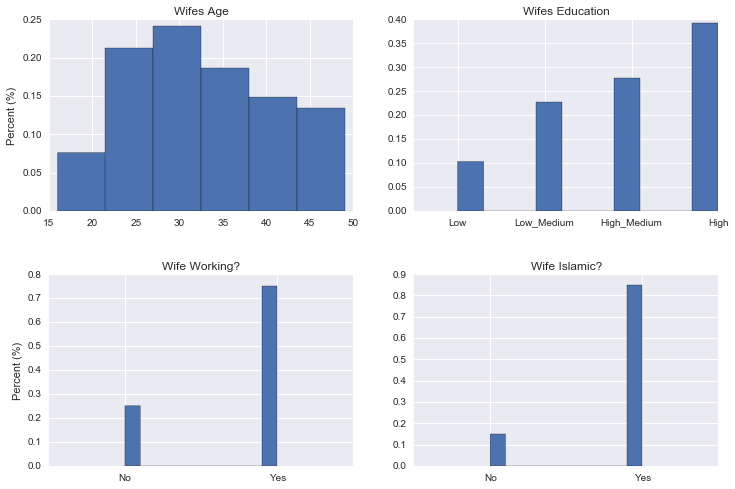

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('Wifes Age')
plt.hist(df.Wife_Age, bins = 6, weights=np.zeros_like(df.Wife_Age) + 1. / df.Wife_Age.size)
plt.ylabel('Percent (%)')

plt.subplot(2,2,2)
plt.title('Wifes Education')
plt.hist(df.Wife_Education, weights=np.zeros_like(df.Wife_Education) + 1. / df.Wife_Education.size)

plt.xticks([1,2,3,4], ['Low','Low_Medium', 'High_Medium','High'])

plt.subplot(2,2,3)
plt.title('Wife Working?')
plt.hist(df.Wife_Working, weights=np.zeros_like(df.Wife_Working) + 1. / df.Wife_Working.size)
plt.ylabel('Percent (%)')
plt.xlim(-0.5,1.5)
plt.xticks([0,1], ['No','Yes'])

plt.subplot(2,2,4)
plt.title('Wife Islamic?')
plt.hist(df.Wife_Islamic, weights=np.zeros_like(df.Wife_Islamic) + 1. / df.Wife_Islamic.size)
plt.xlim(-0.5,1.5)
plt.xticks([0,1], ['No','Yes'])

plt.subplots_adjust(hspace = 0.33)


# MAJORITY ARE YOUNG (40% btwn 20-30yrs), HIGHLY EDUCATED (40%), WORKING (75%), ISLAMIC WOMEN (85+%)

###### Distributions of Husbands Education Level and Families Standard of Living Index

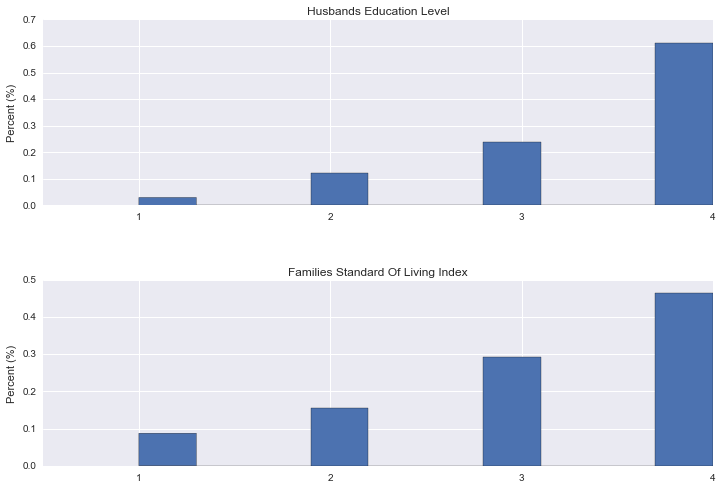

In [6]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('Husbands Education Level')
plt.hist(df.Husband_Education, weights= np.zeros_like(df.Husband_Education) + 1./len(df))
plt.xticks([1,2,3,4])
plt.ylabel('Percent (%)')

plt.subplot(2,1,2)
plt.title('Families Standard Of Living Index')
plt.hist(df.Standard_of_Living_Index, weights = np.zeros_like(df.Standard_of_Living_Index) + 1./len(df))
plt.xticks([1,2,3,4])
plt.ylabel('Percent (%)')
plt.subplots_adjust(hspace = 0.4)

# MAJORITY ARE HIGHLY EDUCATED HIGH SOL FAMILIES

###### Distributions of Number of Children in the Family

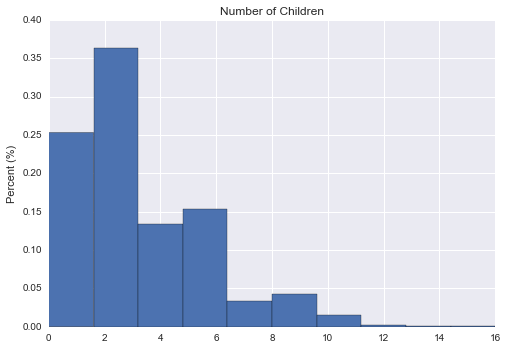

In [7]:
plt.hist(df.Num_Children, weights= np.zeros_like(df.Num_Children) + 1./len(df))
plt.title('Number of Children')
plt.ylabel('Percent (%)')

###### Distributions of Contraceptive Methods Used

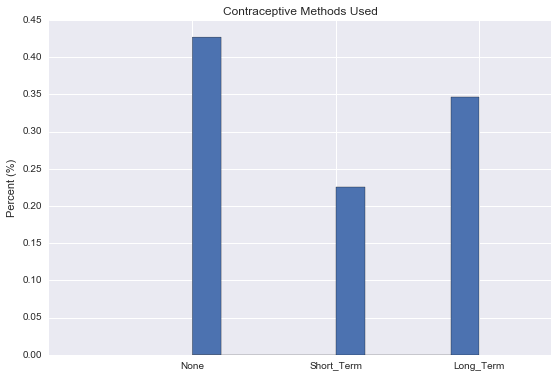

In [8]:
plt.figure(figsize=(9,6))
plt.hist(df.Contraceptive_Method, weights = np.zeros_like(df.Contraceptive_Method) + 1./len(df))
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])
plt.xlim(0,3.5)
plt.title('Contraceptive Methods Used')
plt.ylabel('Percent (%)')

### Correlations

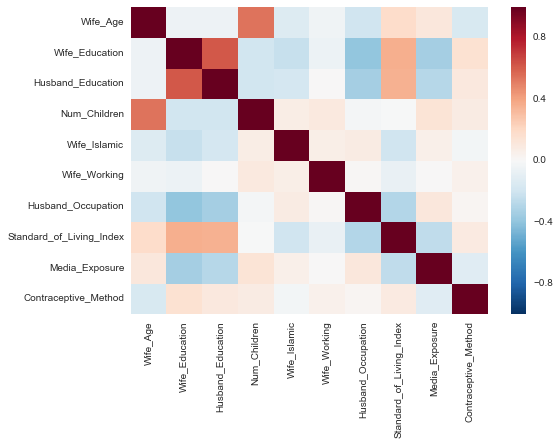

In [9]:
sns.heatmap(df.corr()) # not looking to good

### DeSkew

In [10]:
print df.skew()

df.drop('Media_Exposure', axis = 1, inplace=True) # don't get this column...


Wife_Age                    0.256449
Wife_Education             -0.510366
Husband_Education          -1.266148
Num_Children                1.099014
Wife_Islamic               -1.969500
Wife_Working               -1.152742
Husband_Occupation         -0.098918
Standard_of_Living_Index   -0.836139
Media_Exposure              3.258111
Contraceptive_Method        0.156106
dtype: float64


In [11]:

# # make it positive
# n_child = df.Num_Children + 0.01 

# print 'Normal:', n_child.skew()
# print 'Sqrt:', np.sqrt(n_child).skew()
# print 'Log:', np.log2(n_child).skew()
# print 'BoxCox:', stats.skew(stats.boxcox(n_child)[0])

# # for simplicity i'm gonna go with sqrt
# plt.figure(figsize=(9,6))
# plt.subplot(1,2,1)
# plt.hist(df.Num_Children)
# plt.title('Before Sqrt')
# plt.subplot(1,2,2)
# plt.hist(np.sqrt(df.Num_Children))
# plt.title('After Sqrt')
# print 'actual skew with sqrt transform', np.sqrt(df.Num_Children).skew()

# df.Num_children = np.sqrt(df.Num_Children)



## NAs

In [12]:
df.isnull().sum() # perfect...

Wife_Age                    0
Wife_Education              0
Husband_Education           0
Num_Children                0
Wife_Islamic                0
Wife_Working                0
Husband_Occupation          0
Standard_of_Living_Index    0
Contraceptive_Method        0
dtype: int64

## Logistic Regregression

Accuracy: 0.499463795752


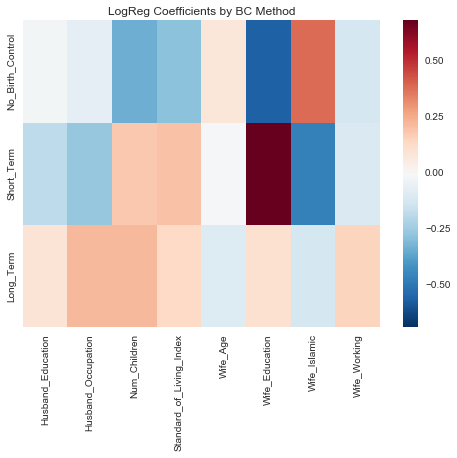

In [13]:
logReg = LogisticRegression()

x = df.ix[:,:-1]
y = df.Contraceptive_Method

# pretty bad
print 'Accuracy:', cross_val_score(logReg, x, y, cv = 50).mean()


# fit data
logReg.fit(x,y)

# create DataFrame of Coefficients for all features for each response (No_BC, Short_Term, Long_Term)
No_BC = sorted(zip(x.columns, logReg.coef_[0]), key = lambda r: np.abs(r[1]))[::-1]
Short_Term = sorted(zip(x.columns, logReg.coef_[1]), key = lambda r: np.abs(r[1]))[::-1]
Long_Term = sorted(zip(x.columns, logReg.coef_[2]), key = lambda r: np.abs(r[1]))[::-1]

No_BC = {c[0]: c[1] for c in No_BC}
Short_Term = {c[0]: c[1] for c in Short_Term}
Long_Term = {c[0]: c[1] for c in Long_Term}
No_BC = pd.DataFrame([No_BC])
Short_Term = pd.DataFrame([Short_Term])
Long_Term = pd.DataFrame([Long_Term])

bcs = pd.concat([No_BC, Short_Term, Long_Term])
bcs.index = ['No_Birth_Control', 'Short_Term', 'Long_Term']
sns.heatmap(bcs)
plt.title('LogReg Coefficients by BC Method')


The major factors seem to be Education and to some degree Religion. The former leads to greater use of Short Term Birth Control, while the later seems to correlate with less use (or at least reporting).

The war between science and religion over womens bodies...

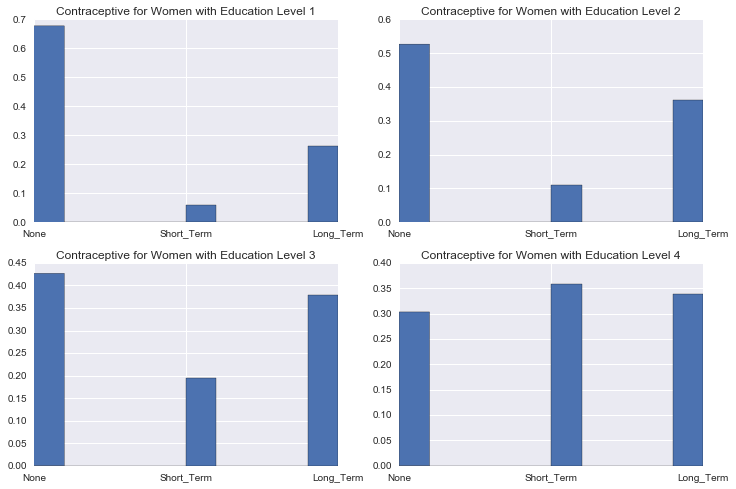

In [14]:
# LOOK AT WIFES EDUCATION

plt.figure(figsize=(12,8))
s = 1
for ed in sorted(df.Wife_Education.unique()):
    plt.subplot(2,2,s)
    plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])
    plt.title('Contraceptive for Women with Education Level %s' %ed)
    plt.hist(df[df.Wife_Education == ed].Contraceptive_Method, 
             weights = np.zeros_like(df[df.Wife_Education == ed].Contraceptive_Method) + 1./len(df[df.Wife_Education == ed]))
    s+=1

sp1 = plt.subplot(2,2,1)



Higher education seems to lead to more even distribution of <u>choices</u>.

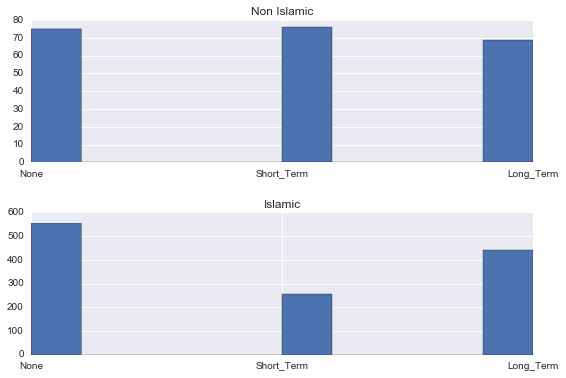

In [15]:
# LOOK AT ISLAMIC?

fig = plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
plt.title('Non Islamic')
plt.hist(df[df.Wife_Islamic == 0].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplot(2,1,2)
plt.title('Islamic')
plt.hist(df[df.Wife_Islamic == 1].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplots_adjust(hspace = 0.35)

This would seem to indicate that Islamic women have an aversion to Short_Term methods. However, the data includes way more Islamic women than not so it's hard to come to any conclusions on this.

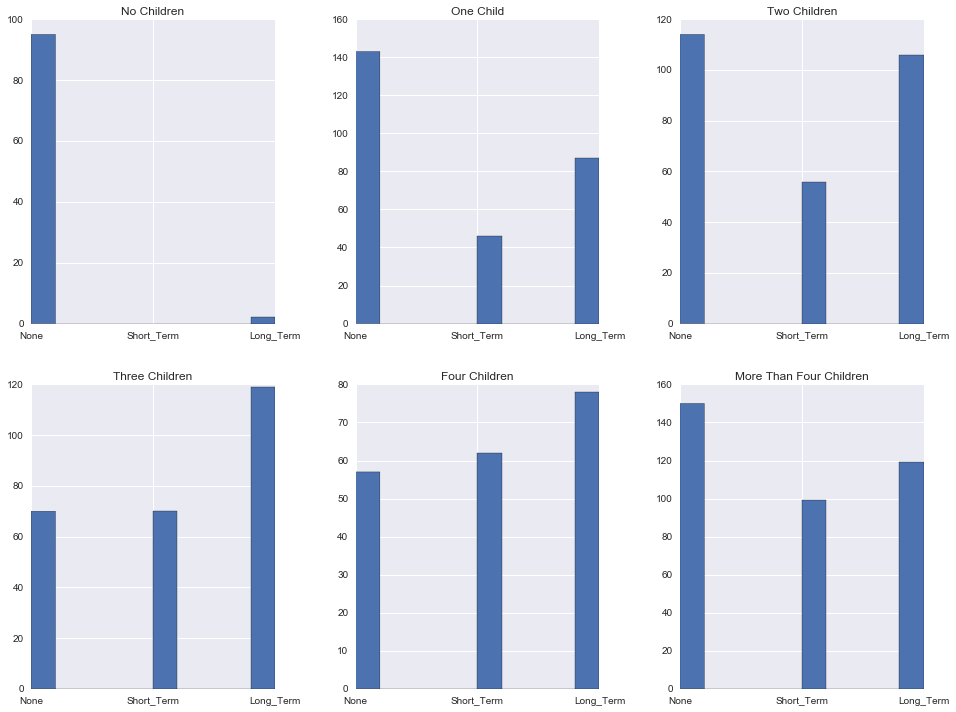

In [16]:
# LOOK AT NUM CHILDREN
fig = plt.figure(figsize=(16,12))

plt.subplot(2,3,1)
plt.title('No Children')
plt.hist(df[df.Num_Children == 0].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplot(2,3,2)
plt.title('One Child')
plt.hist(df[df.Num_Children == 1].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplot(2,3,3)
plt.title('Two Children')
plt.hist(df[df.Num_Children == 2].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplot(2,3,4)
plt.title('Three Children')
plt.hist(df[df.Num_Children == 3].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplot(2,3,5)
plt.title('Four Children')
plt.hist(df[df.Num_Children == 4].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplot(2,3,6)
plt.title('More Than Four Children')
plt.hist(df[df.Num_Children > 4].Contraceptive_Method)
plt.xticks([1,2,3], ['None','Short_Term', 'Long_Term'])

plt.subplots_adjust(wspace = 0.33)

Seems like as women have more children they start using birth control more.

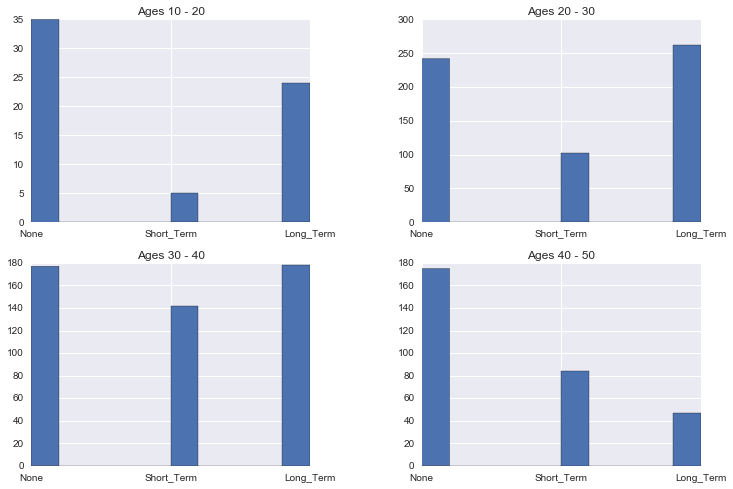

In [17]:
# METHOD BY AGE
bins = [10,20,30,40,50]
df['Age_Bin'] = pd.cut(df.Wife_Age, bins=bins)
age_bins = df.Age_Bin.unique()
age_bins.sort()
fig = plt.figure(figsize=(12,8))
s = 1
for a in age_bins:
    plt.subplot(2,2,s)
    plt.hist(df[df.Age_Bin == a].Contraceptive_Method)
    plt.xticks([1,2,3], ['None', 'Short_Term', 'Long_Term'])
    plt.title('Ages %s - %s' %(a[1:3], a[5:7])) 
    s +=1

plt.subplots_adjust(wspace = 0.4)


Majority of contraceptive users are between 20-40 years old. You see a sharp decline in contraceptive use once you look at women older than 40. Perhaps this is a generational thing. Older women may not still be in school, may be less attuned to modern concepts in reproductive health or less sexually active.

([<matplotlib.axis.XTick at 0x111f55e50>,
 <a list of 4 Text xticklabel objects>)

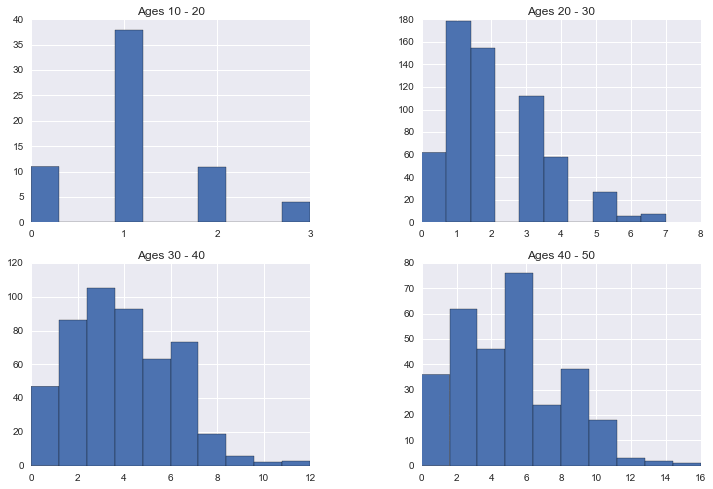

In [18]:
# NUM CHILDREN BY AGE


fig = plt.figure(figsize=(12,8))
s = 1
for a in age_bins:
    plt.subplot(2,2,s)
    plt.hist(df[df.Age_Bin == a].Num_Children)
    plt.title('Ages %s - %s' %(a[1:3], a[5:7])) 
    s +=1

plt.subplots_adjust(wspace = 0.4)
plt.subplot(2,2,1)
plt.xticks(range(4))

The questionable thing here is that older women tend to have more children. This conflicts slightly with the two ideas presented previously that as women have more children they tend to start using some form of birth control, yet the majority of women over 40 are not using any birth control. Could be due to a number of different things but future investigation is merrited as this may be a source of erroroneous predictions in my models.

### Examine The model in more detail including AUC score and Presicion/Recall

__Precision Score__ is the percent of the models predictions that were correct in respect ot a given response 

__Recall__ is the percent of the actual number of hits that our model correctly predicted in respect to a given response

In [27]:
# Examine the models metrics in more detail
x = df.ix[:,:-2]
y = df.Contraceptive_Method

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.33, random_state = 123)

logReg = LogisticRegression()
logReg.fit(x_train, y_train)

preds = logReg.predict(x_test)

confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, preds), 
             index = ['None', 'Short_Term','Long_Term'], columns = ['None', 'Short_Term','Long_Term'])
confusion_matrix.index.name = 'Actual'
confusion_matrix.columns.name = 'Predicted'
print 'Confusion Matrix: \n\n', confusion_matrix, '\n'

print 'Classification Report: \n'
print metrics.classification_report(y_test, preds)


# Error: 'Multi_class not supported'. does this mean i need to one_hot encode response??
# print 'AUC Score for No Birth Control', metrics.roc_auc_score(y_test, logReg.predict_proba(x_test)[:,0])
# print 'AUC Score for Short Term', metrics.roc_auc_score(y_test, logReg.predict_proba(x_test)[:,1])
# print 'AUC Score for Long Term', metrics.roc_auc_score(y_test, logReg.predict_proba(x_test)[:,2])


Confusion Matrix: 

Predicted   None  Short_Term  Long_Term
Actual                                 
None         140          14         50
Short_Term    43          23         44
Long_Term     67          22         84 

Classification Report: 

             precision    recall  f1-score   support

          1       0.56      0.69      0.62       204
          2       0.39      0.21      0.27       110
          3       0.47      0.49      0.48       173

avg / total       0.49      0.51      0.49       487



What the above shows is that our model completely shat the bed in terms of predicting short_term birth control use. It's predictions only captured 21% of all the actual women who actually used short_term contraceptive methods (recall??) and 51% of it's short_term predictions were wrong (precision??)

A future goal would be to use this information to examine the details of the data to find out what's causing such poor performance, particularly in the inability to predict Short_Term method users, and the seeming confusion between No Birth Control and Long_Term Method users.

### POLYNOMIAL FEATURES

In [29]:
# 2 DEGREES
poly2 = PolynomialFeatures(degree = 2, interaction_only=True)

logReg = LogisticRegression()

x = df.ix[:,:-2]
x = poly2.fit_transform(x)
y = df.Contraceptive_Method

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 123)

# SLIGHTLY IMPROVED
print 'Accuracy:',cross_val_score(logReg, x, y, cv = 50).mean()

logReg.fit(x_train,y_train)
preds = logReg.predict(x_test)

print metrics.classification_report(y_test, preds)


Accuracy: 0.542095926691
             precision    recall  f1-score   support

          1       0.58      0.73      0.65       204
          2       0.51      0.30      0.38       110
          3       0.55      0.52      0.53       173

avg / total       0.55      0.56      0.55       487



In [30]:
# 3 DEGREES WITH REGULARIZATION

# THIS TAKES TOO LONG

poly3 = PolynomialFeatures(degree = 3, interaction_only=True)

# applying strong L1 regularization (Low C = stronger Regularization, Higher C = Less Regularization)
logReg = LogisticRegression(penalty='l1', C=0.1)

x = df.ix[:,:-2]
x = poly3.fit_transform(x)
y = df.Contraceptive_Method

# SAME
print 'Accuracy:',cross_val_score(logReg, x, y, cv = 20).mean()



Accuracy: 0.541042237443


## DECISION TREE

In [31]:
rForest = RandomForestClassifier(n_estimators=15)

x = df.ix[:,:-2]
y = df.Contraceptive_Method

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 123)


print 'Accuracy:', cross_val_score(rForest, x, y, cv = 20).mean()

rForest.fit(x_train, y_train)
preds = rForest.predict(x_test)
print '\n'
print metrics.classification_report(y_test, preds)

Accuracy: 0.501934900654


             precision    recall  f1-score   support

          1       0.56      0.64      0.60       204
          2       0.39      0.30      0.34       110
          3       0.47      0.46      0.47       173

avg / total       0.49      0.50      0.49       487



#### Run a grid search using varying max_depth and max_features

In [34]:
max_depth = range(2,10)
max_ftrs = ['sqrt','log2', None]
param_dic = {'max_depth': max_depth, 'max_features': max_ftrs}

rForest = RandomForestClassifier(n_estimators=15, n_jobs=-1)

x = df.ix[:,:-2]
y = df.Contraceptive_Method

grid = GridSearchCV(rForest, param_dic, cv = 20, scoring='accuracy')
grid.fit(x,y)

pass

In [35]:
grid.grid_scores_

print 'Best Parameters:', grid.best_params_
print 'Best Score:', grid.best_score_

print 'Feature Importances: \n'
sorted(zip(x.columns, grid.best_estimator_.feature_importances_), key = lambda a: np.abs(a[1]))[::-1]

Best Parameters: {'max_features': None, 'max_depth': 6}
Best Score: 0.56754921928
Feature Importances: 



[('Num_Children', 0.33918624530755903),
 ('Wife_Age', 0.32019328503254013),
 ('Wife_Education', 0.17843549541165241),
 ('Husband_Occupation', 0.053241470240978396),
 ('Standard_of_Living_Index', 0.044582475974352116),
 ('Husband_Education', 0.035215965536881118),
 ('Wife_Working', 0.015228631405124973),
 ('Wife_Islamic', 0.013916431090911851)]

The best estimator is slightly better than our random forrest, but max_features is None... so overfitting??

In [36]:
rf = grid.best_estimator_

# ok good sign not overfit
print 'Accuracy:', cross_val_score(rf, x, y, cv = 25, scoring='accuracy').mean()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 123)

rf.fit(x_train, y_train)
preds = rf.predict(x_test)

c_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, preds), 
                        index = ['None','Short_Term','Long_Term'], columns = ['None','Short_Term','Long_Term'])
c_matrix.index.name = 'Actual'
c_matrix.columns.name = 'Predicted'


print 'Confusion Matrix: \n\n', c_matrix, '\n'

print 'Classification Report: \n', metrics.classification_report(y_test, preds)


Accuracy: 0.559506765928
Confusion Matrix: 

Predicted   None  Short_Term  Long_Term
Actual                                 
None         128          15         61
Short_Term    24          49         37
Long_Term     39          25        109 

Classification Report: 
             precision    recall  f1-score   support

          1       0.67      0.63      0.65       204
          2       0.55      0.45      0.49       110
          3       0.53      0.63      0.57       173

avg / total       0.59      0.59      0.59       487



In [40]:
# ACCURACY FROM RANDOMLY CHOOSING A VALUE

random_accuracy = []
for _ in range(100):
    random_accuracy.append(metrics.accuracy_score(np.random.choice([1,2,3],len(y)), y))

random_accuracy = np.array(random_accuracy)
np.mean(random_accuracy)

0.33306856754921932

In [41]:
# NULL ACCURACY

x = df.ix[:,:-2]
y = df.Contraceptive_Method

for strat in ['stratified', 'most_frequent', 'uniform']:
    dumb = DummyClassifier(strategy = strat)
    print cross_val_score(dumb, x, y, cv = 30).mean()

0.386437141523
0.427042950514
0.32377314259


So random accuracy is 33% (eg 1 for each possible value of y) and our dummy classifier is 42% accurate based on our distribution. So our Random Forest or Log Reg is about 10-15% more accurate than our best dummy classifier. However, 55% is not that great... 

In [56]:
x = df.ix[:,:-2]
y = df.Contraceptive_Method

svc = SVC(C = 0.2)
print 'SVC:', cross_val_score(svc, x, y, cv = 20).mean()

ada = AdaBoostClassifier()
print 'AdaBoost:', cross_val_score(ada, x, y, cv = 20).mean()

ETC = ExtraTreesClassifier(n_estimators = 20, max_features='sqrt')
print 'Extra Trees:', cross_val_score(ETC, x, y, cv = 20).mean()

GBCD = GradientBoostingClassifier(learning_rate=0.05, max_features=0.5)
print 'Gradient Boost Deviance:', cross_val_score(GBCD, x, y, cv = 20).mean()




SVC: 0.54315285491
AdaBoost: 0.543652597803
Extra Trees: 0.492527500103
Gradient Boost Deviance: 0.558902350981


In [60]:
ests = [('LogReg', logReg),('SVC', svc), ('AdaBoost', ada), 
              ('RandomForest',rForest), ('GradientBoost', GBCD)]

voting_hard = VotingClassifier(ests)
voting_soft = VotingClassifier(ests, voting='soft')

print 'Hard Vote:', cross_val_score(voting_hard, x, y, cv=20).mean()
print 'Soft Vote:', cross_val_score(voting_hard, x, y, cv=20).mean()

Hard Vote: 0.557864813444
Soft Vote: 0.559855804435


## K Neighbors Classifier

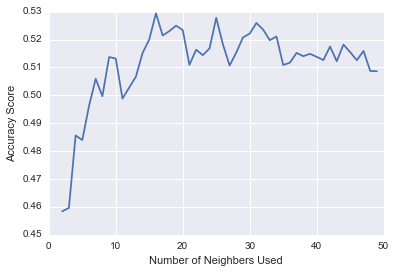

In [119]:
from sklearn.neighbors import KNeighborsClassifier


x = df.ix[:,:-1]
x = StandardScaler().fit_transform(x)
y = df.Contraceptive_Method

# vary n_neighbors param
kneighbors_scores = []
for n in range(2,50):
    kn = KNeighborsClassifier(n_neighbors=n)
    kneighbors_scores.append(cross_val_score(kn, x, y, cv = 50, scoring = 'accuracy').mean())
plt.plot(range(2,50), kneighbors_scores)
plt.xlabel('Number of Neighbers Used')
plt.ylabel('Accuracy Score')
# Stabalizes between 15-20

In [120]:
# Adding Weights so that each prediction is based on the distance from its n_neighbors

weighted_scores = []
for n in range(15,20):
    kn = KNeighborsClassifier(n_neighbors=n, weights='distance', p = 2) # use Euclidian (instead of minkowski)
    weighted_scores.append(cross_val_score(kn, x, y, cv = 50, scoring = 'accuracy').mean())
zip(range(15,20), weighted_scores)

# performs worse than unweighted

[(15, 0.48451125589279087),
 (16, 0.49185677207479211),
 (17, 0.49315774140579477),
 (18, 0.49849732507018379),
 (19, 0.49391519677949047)]

Lastly I'm goin to split the data into two binary sections. 
* The first section is going to just predict whether a women is on birth control AT ALL.
* The second is going to take the women that are on birth control and predict what type (short_term vs long_term)


In [122]:
# SPLITTING EVALUATION INTO BINARY PREDICTION
    # 1) BIRTH CONTROL OR NO BIRTH CONTROL

df['Birth_Control']= df.Contraceptive_Method >1
df.Birth_Control = df.Birth_Control.astype('int64')

x = df.ix[:,:-2]
y = df.Birth_Control

logReg = LogisticRegression()

print "Accuracy of LogReg of x:", cross_val_score(logReg, x, y, cv = 50).mean()
print "Precision of LogReg of x:", cross_val_score(logReg, x, y, cv = 50, scoring='precision').mean()
print "Recall of LogReg of x:", cross_val_score(logReg, x, y, cv = 50, scoring='recall').mean()
print '\n'

poly2 = PolynomialFeatures(degree = 2, interaction_only=True)
x = poly2.fit_transform(x)

print 'Accuracy of LogReg of Poly2X: ', cross_val_score(logReg, x, y, cv = 50).mean()
print "Precision of LogReg of Poly2x:", cross_val_score(logReg, x, y, cv = 50, scoring='precision').mean()
print "Recall of LogReg of Poly2x:", cross_val_score(logReg, x, y, cv = 50, scoring='recall').mean()
print '\n'

x = df.ix[:,:-2]
rForest = RandomForestClassifier(n_estimators=25, max_depth=5)

print 'Accuracy of Random Forest x:', cross_val_score(rForest, x, y, cv = 20).mean()
print 'Precision of Random Forest x:', cross_val_score(rForest, x, y, cv = 20, scoring = 'precision').mean()
print 'Recall of Random Forest x:', cross_val_score(rForest, x, y, cv = 20, scoring = 'recall').mean()

Accuracy of LogReg of x: 0.666998357964
Precision of LogReg of x: 0.677774830201
Recall of LogReg of x: 0.805588235294


Accuracy of LogReg of Poly2X:  0.712075533662
Precision of LogReg of Poly2x: 0.719045534833
Recall of LogReg of Poly2x: 0.823455882353


Accuracy of Random Forest x: 0.691748364803
Precision of Random Forest x: 0.684751868697
Recall of Random Forest x: 0.901661129568


This seems to suggest that all of our models lean towards just guessing that the woman is on birth control, hence higher recall (eg we get more of those right at the cost of less precision).

In [129]:

    # 2) TYPE OF Birth_Control
    
x = df[df.Contraceptive_Method >1]
y = x.Contraceptive_Method
y = y-2
x = x.ix[:,:-2]

logReg = LogisticRegression()

print "Accuracy of LogReg of x:", cross_val_score(logReg, x, y, cv = 50).mean()
print "Precision of LogReg of x:", cross_val_score(logReg, x, y, cv = 50, scoring='precision').mean()
print "Recall of LogReg of x:", cross_val_score(logReg, x, y, cv = 50, scoring='recall').mean()
print '\n'

poly2 = PolynomialFeatures(degree = 2, interaction_only=True)
x = poly2.fit_transform(x)

print 'Accuracy of LogReg of Poly2X: ', cross_val_score(logReg, x, y, cv = 50).mean()
print "Precision of LogReg of Poly2x:", cross_val_score(logReg, x, y, cv = 50, scoring='precision').mean()
print "Recall of LogReg of Poly2x:", cross_val_score(logReg, x, y, cv = 50, scoring='recall').mean()
print '\n'

x = df[df.Contraceptive_Method >1]
y = x.Contraceptive_Method
y = y-2
x = x.ix[:,:-2]


rForest = RandomForestClassifier(n_estimators=25, max_depth=5)

print 'Accuracy of Random Forest x:', cross_val_score(rForest, x, y, cv = 20).mean()
print 'Precision of Random Forest x:', cross_val_score(rForest, x, y, cv = 20, scoring = 'precision').mean()
print 'Recall of Random Forest x:', cross_val_score(rForest, x, y, cv = 20, scoring = 'recall').mean()

Accuracy of LogReg of x: 0.637205882353
Precision of LogReg of x: 0.680455932956
Recall of LogReg of x: 0.773636363636


Accuracy of LogReg of Poly2X:  0.64489379085
Precision of LogReg of Poly2x: 0.690733821734
Recall of LogReg of Poly2x: 0.766181818182


Accuracy of Random Forest x: 0.636087702239
Precision of Random Forest x: 0.672863890715
Recall of Random Forest x: 0.776846153846


Similarly our model has a slight tendency to just predict Long_Term leading to higher recall at the cost of precision.

## Conclusion

So far I've looked at variations of 3 different types of estimators: Logistic Regression, Random Forest Classifier, and K Neighbors Classifier. All 3 predicted a woman's contraceptive method with approximately 50% accuracy. Fine tuning the parameters, I was able to raise that number to 55% but questions remain about over-fitting the model. All three models were completely unable to identify woman using a short-term contraceptive method and seemed to frequently confuse women not using any birth control and women who used long term methods. Further investigation is required to examine what similarities are shared between the women who do not use any method and those who use the long term method that may inhibit the model. Additionally, examining the data on women who used short term methods could give some clues as to why the model so drastically underperformed in that area. 


However we were able to see a few interesting relationships simply be exploring the data. Most prominent was that the distribution of contraceptive method choice spread out as we looked at women with higher degrees of education. The 1987 National Indonesia Contraceptive Prevalence Survey was conducted in part as a response to data suggesting that the fertility rate (number of children a women has in her reproductive lifetime) had decreased in the 5 years prior. Unfortunately, the location of the families is not included in our subset of the data, but the study found that increased contraceptive use most dramatic in the provinces of Java and Bali. These also "happen" to be the locations where the Indonesian Government first launched their family planning and education services. This suggests the (somewhat scary and not at all novel) idea that many unintentional pregnancies could have been prevented had the women simply KNOWN about her options.

The second relationship we saw in the data was the one between islamic women and contraceptive use. Even though non-islamic women were under-represented in the data, there was still a clear decline in contraceptive use amongst islamic women.

Finally, my future projects may investigate the relationships between age and number of children in a family as these both seem to be likely candidates for causing inaccuracy in my models. Additional information that's more current, represents a broader spectrum of the population, and contains more detailed information on families socio-economic status would be essential for improving models that would be useful in terms of reproductive health in society.